In [34]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Outcar
from pymatgen.electronic_structure.core import Spin
import numpy as np

import pandas as pd

from os.path import expanduser
home = expanduser('~')

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


def format_ladder(orbitals, occu_matrix, spin=None):
    ladder = np.array(sorted(zip(np.diag(occu_matrix), orbitals), reverse=True))
    occu_ladder = ladder[:,0]
    orb_ladder = ladder[:,1]
    if spin == 1:
        row1 = '/\ Orbital:   '
        row2 = '/\ Occupation:'
    elif spin == -1:
        row1 = '\/ Orbital:   '
        row2 = '\/ Occupation:'
    for i in range(len(occu_ladder)):
        row1 = row1 + f'\t{orb_ladder[i]}'
        row2 = row2 + f'\t{occu_ladder[i]}'
    return row1 + '\n' + row2


def display_occu(odm, orbitals, order=None, print_ladder=True):
    up = odm[Spin.up]
    down = odm[Spin.down]
    
    ### Write header
    header = '\t'
    if order == None: order = range(5)
    for i in order:
        header = f'{header}{orbitals[i]}\t\t'
    print(header, end='')
    
    ### Write each row
    for i in order:
        print(f'\n{orbitals[i]}', end='\t')
        for j in order:
            entries = [np.round(up[i][j], 2), np.round(down[i][j], 2)]
            for k in range(2):
                if entries[k] == 0:
                    entries[k] = '----'
            print(f'{entries[0]} / {entries[1]}', end='\t')
    print('\n')
    if print_ladder:
        print(format_ladder(orbitals, up, spin=1))
        print()
        print(format_ladder(orbitals, down, spin=-1))
#         up_ladder = zip(np.diag(up), orbitals)
#         up_ladder =  sorted(up_ladder, reverse=True)
#         print(np.array(up_ladder).T)
#         print('\n')
        
#         dn_ladder = zip(np.diag(down), orbitals)
#         dn_ladder =  sorted(dn_ladder, reverse=True)
#         print(np.array(dn_ladder).T)
#         print('\n')
    

def print_occupations(iters, orbitals, n_with_U, order=None, atom_idx=0):
    odms = []
    for i, iter_1 in enumerate(iters):
            label = f'{iter_1}'
            outcar = Outcar(f'{PREFIX}-{label}{SUFFIX}')
            outcar.read_onsite_density_matrices()
            odm = outcar.data['onsite_density_matrices'][-n_with_U:] # we only want to odm from last iter
            odms.append(odm)
            print(f'##### {iter_1} #####')
            display_occu(odm[atom_idx], orbitals, order=order)
            print()

            
def parse_diag_occus(iters, orbitals, n_with_U, order=None, atom_idx=0, spin=-1):
    odms = []
    diag_occus = []
    for i, iter_1 in enumerate(iters):
        label = f'{iter_1}'
        ### jank fix for spin swapped run
        if label == 'exp_P4nmm_e249.5':
            print('activated')
            tmp_atom_idx = 6
        else:
            tmp_atom_idx = atom_idx
        ####################################
        outcar = Outcar(f'{PREFIX}-{label}{SUFFIX}')
        outcar.read_onsite_density_matrices()
        odm = outcar.data['onsite_density_matrices'][-n_with_U:] # we only want to odm from last iter
        odms.append(odm)
        
        # Diagonalized
        if spin == -1:
            occu_matrix = odm[tmp_atom_idx][Spin.down]
        elif spin == 1:
            occu_matrix = odm[tmp_atom_idx][Spin.up]
        else:
            print("Invalid spin, should be +/- 1")
            return
        diag_occu = np.diag(occu_matrix)
        diag_occu = [diag_occu[i] for i in order]
        diag_occus.append(diag_occu)
    ordered_orbitals = [orbitals[i] for i in order] 
    df = pd.DataFrame(diag_occus, columns=ordered_orbitals)
    df.insert(0, 'e', ITERS_2)
    return df


def plot_diag_occus(label, df, legend_labels):
    fig = plt.figure(figsize=(4,3.5))
    x = df['e']
    for i in range(len(legend_labels)):
        if legend_labels[i] in ['$d_{yz}$', '$d_{xz}$']:
            plt.plot(x, df[df.columns[i+1]], 'x--', label=legend_labels[i])
        else:
            plt.plot(x, df[df.columns[i+1]], 'o-', label=legend_labels[i])
    plt.xlabel('Electron Count')
    plt.ylabel('Orbital Occupancy')
    plt.grid(1)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1, 1.3), ncol=5)
    plt.show()
    fig.savefig(f'diag-occu_{label}.png', dpi=300, bbox_inches='tight')
        
### Unrotated
orbitals_fancy = ['$d_{x^2 - y^2}$', '$d_{yz}$', '$d_{z^2 - r^2}$', '$d_{xz}$', '$d_{xy}$']
orbitals = ['d_x2-y2', 'd_yz', 'd_z2-r2', 'd_xz', 'd_xy']
order = [4, 1, 3, 2, 0]

### Rotated to align with VASP default (ligands along xyz)
rot_orbitals_fancy = ['$d_{xy}$', '$d_{yz}$', '$d_{z^2 - r^2}$', '$d_{xz}$', '$d_{x^2 - y^2}$']
rot_orbitals = ['d_xy', 'd_yz', 'd_z2-r2', 'd_xz', 'd_x2-y2']
rot_order =  [0, 1, 3, 2, 4] #ordering is just for cosmetics -- xz near yz




exp_eta


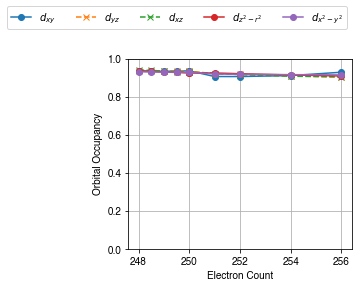

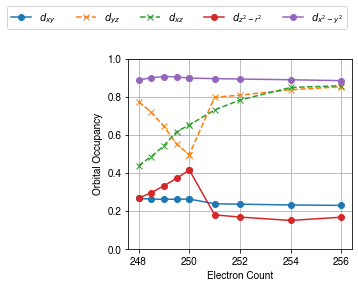

In [37]:
### eta
PREFIX = '/mnt/c/Users/kyledmiller/GoogleDrive/data/BaCoS2/nelect-estruc/OUTCAR'
SUFFIX = ''

ITERS_1 = ['eta']
ITERS_2 = [248, 248.5, 249, 249.5, 250, 250, 251, 252, 254, 256]

for prefix in [f'exp_{iter1}' for iter1 in ITERS_1]:
    ITERS = [f'{prefix}_e{iter2}' for iter2 in ITERS_2]
    print('\n' + prefix)

    for spin in [1, -1]:
        df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=0, spin=spin)
        plot_diag_occus(prefix, df, [rot_orbitals_fancy[i] for i in rot_order])


exp_sm-P2c


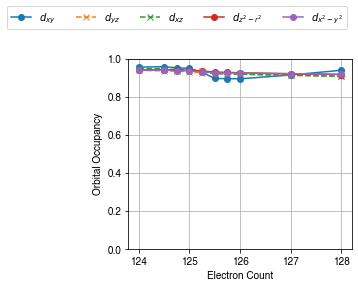

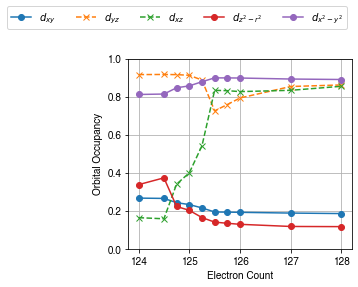

In [35]:
### sm-P2c
PREFIX = '/mnt/c/Users/kyledmiller/GoogleDrive/data/BaCoS2/nelect-estruc/OUTCAR'
SUFFIX = ''

ITERS_1 = ['sm-P2c']
ITERS_2 = [124, 124.5, 124.75, 125, 125.25, 125.5, 125.75, 126, 127, 128]

for prefix in [f'exp_{iter1}' for iter1 in ITERS_1]:
    ITERS = [f'{prefix}_e{iter2}' for iter2 in ITERS_2]
    print('\n' + prefix)
    for spin in [1, -1]:
        df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=4, order=rot_order, atom_idx=0, spin=spin)
        plot_diag_occus(prefix, df, [rot_orbitals_fancy[i] for i in rot_order])


exp_P4nmm
activated


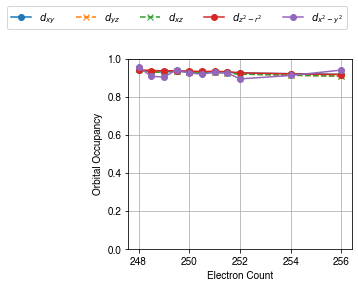

activated


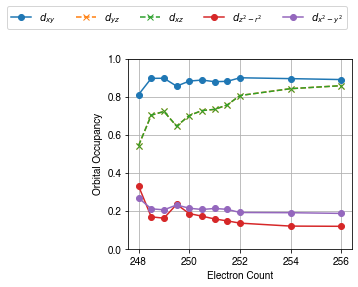


exp_Pba2


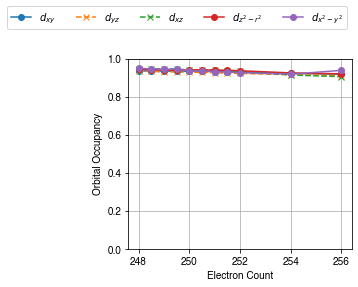

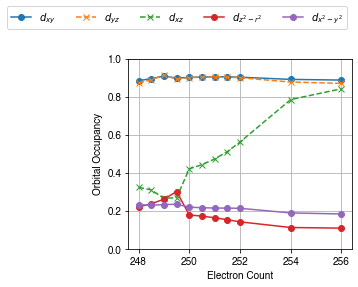


exp_P2c


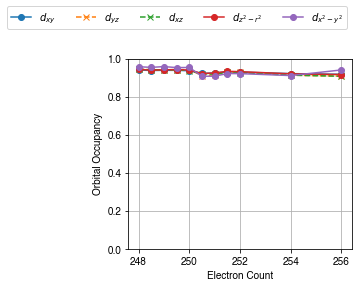

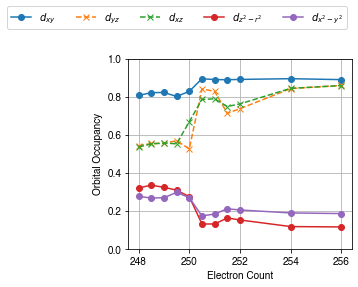

In [36]:
### Diagonalized
PREFIX = '/mnt/c/Users/kyledmiller/GoogleDrive/data/BaCoS2/nelect-estruc/OUTCAR'
SUFFIX = ''

ITERS_1 = ['P4nmm', 'Pba2', 'P2c']
ITERS_2 = [248, 248.5, 249, 249.5, 250, 250.5, 251, 251.5, 252, 254, 256]

for prefix in [f'exp_{iter1}' for iter1 in ITERS_1]:
    ITERS = [f'{prefix}_e{iter2}' for iter2 in ITERS_2]
    print('\n' + prefix)

    for spin in [1, -1]:
        df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=0, spin=spin)
        plot_diag_occus(prefix, df, [rot_orbitals_fancy[i] for i in rot_order])
    

In [19]:
PREFIX = home + '/Projects/BaCoS2/correct_mag/u-estruc/OUTCAR'
SUFFIX = ''

prefix = 'exp_P4nmm_U'

ITERS = [0, 2, 4]
ITERS = [prefix + str(item) for item in ITERS]
for i in range(1):
    print_occupations(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=i)

# print_occupations(ITERS, orbitals,  n_with_U=8, order=order, atom_idx=0)

##### exp_P4nmm_U0 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.91 / 0.85	---- / ----	---- / ----	---- / -0.01	---- / ----	
d_yz	---- / ----	0.91 / 0.64	---- / -0.01	---- / ----	---- / ----	
d_xz	---- / ----	---- / -0.01	0.91 / 0.64	---- / ----	---- / ----	
d_z2-r2	---- / -0.01	---- / ----	---- / ----	0.91 / 0.34	---- / ----	
d_x2-y2	---- / ----	---- / ----	---- / ----	---- / ----	0.86 / 0.32	

/\ Orbital:   	d_xy	d_yz	d_xz	d_z2-r2	d_x2-y2
/\ Occupation:	0.914	0.9064	0.9064	0.9059	0.8623

\/ Orbital:   	d_xy	d_yz	d_xz	d_z2-r2	d_x2-y2
\/ Occupation:	0.8479	0.6411	0.6411	0.3423	0.3237

##### exp_P4nmm_U2 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.94 / 0.81	---- / ----	---- / ----	---- / -0.26	---- / ----	
d_yz	---- / ----	0.94 / 0.54	0.01 / -0.38	---- / ----	---- / ----	
d_xz	---- / ----	0.01 / -0.38	0.94 / 0.54	---- / ----	---- / ----	
d_z2-r2	---- / -0.26	---- / ----	---- / ----	0.94 / 0.33	---- / ----	
d_x2-y2	---- / ----	---- / ----	---- / ----	---- / ----	0.96 / 0.27	


In [6]:
PREFIX = home + '/Projects/BaCoS2/correct_mag/u-estruc/OUTCAR'
SUFFIX = ''

prefix = 'exp_P2c_U'

ITERS = [0, 2, 4]
ITERS = [prefix + str(item) for item in ITERS]
for i in range(1):
    print_occupations(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=i)

# print_occupations(ITERS, orbitals,  n_with_U=8, order=order, atom_idx=0)

##### exp_P2c_U0 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.91 / 0.85	---- / ----	---- / ----	---- / 0.01	---- / ----	
d_yz	---- / ----	0.91 / 0.65	---- / ----	---- / ----	---- / ----	
d_xz	---- / ----	---- / ----	0.91 / 0.65	---- / -0.01	---- / ----	
d_z2-r2	---- / 0.01	---- / ----	---- / -0.01	0.91 / 0.32	---- / ----	
d_x2-y2	---- / ----	---- / ----	---- / ----	---- / ----	0.86 / 0.32	

/\ Orbital:   	d_xy	d_z2-r2	d_xz	d_yz	d_x2-y2
/\ Occupation:	0.914	0.9071	0.9069	0.9067	0.8626

\/ Orbital:   	d_xy	d_xz	d_yz	d_x2-y2	d_z2-r2
\/ Occupation:	0.8484	0.6546	0.646	0.3218	0.32

##### exp_P2c_U2 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.94 / 0.81	---- / -0.06	---- / -0.05	---- / 0.25	---- / ----	
d_yz	---- / -0.06	0.94 / 0.52	-0.01 / 0.35	---- / 0.11	---- / ----	
d_xz	---- / -0.05	-0.01 / 0.35	0.94 / 0.52	---- / 0.12	---- / ----	
d_z2-r2	---- / 0.25	---- / 0.11	---- / 0.12	0.94 / 0.36	---- / ----	
d_x2-y2	---- / ----	---- / ----	---- / ----	---- / ----	0.96 / 0.28	

/\ Orb

In [5]:
PREFIX = home + '/Projects/BaCoS2/correct_mag/u-estruc/OUTCAR'
SUFFIX = ''

prefix = 'exp_Pba2_U'

ITERS = [0, 2, 4]
ITERS = [prefix + str(item) for item in ITERS]
for i in range(1):
    print_occupations(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=i)

# print_occupations(ITERS, orbitals,  n_with_U=8, order=order, atom_idx=0)

##### exp_Pba2_U0 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.92 / 0.84	---- / ----	---- / ----	---- / -0.02	---- / 0.01	
d_yz	---- / ----	0.9 / 0.85	---- / -0.01	---- / ----	---- / ----	
d_xz	---- / ----	---- / -0.01	0.92 / 0.48	---- / ----	---- / ----	
d_z2-r2	---- / -0.02	---- / ----	---- / ----	0.91 / 0.27	---- / -0.04	
d_x2-y2	---- / 0.01	---- / ----	---- / ----	---- / -0.04	0.88 / 0.31	

/\ Orbital:   	d_xz	d_xy	d_z2-r2	d_yz	d_x2-y2
/\ Occupation:	0.9182	0.917	0.9142	0.904	0.8813

\/ Orbital:   	d_yz	d_xy	d_xz	d_x2-y2	d_z2-r2
\/ Occupation:	0.8534	0.8353	0.4751	0.3066	0.269

##### exp_Pba2_U2 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.94 / 0.88	---- / ----	---- / ----	---- / -0.14	---- / 0.03	
d_yz	---- / ----	0.93 / 0.87	---- / -0.17	---- / ----	---- / ----	
d_xz	---- / ----	---- / -0.17	0.95 / 0.32	---- / ----	---- / ----	
d_z2-r2	---- / -0.14	---- / ----	---- / ----	0.94 / 0.22	---- / -0.05	
d_x2-y2	---- / 0.03	---- / ----	---- / ----	---- / -0.05	0.95 / 0.23	

